In [1]:
import tensorflow as tf

from data_loader.kitti_road_data_loader import KittiRoadLoader
from models.unet_model import UNetModel
from trainers.road_trainer import RoadTrainer
from utils.config import process_config
from utils.dirs import create_dirs
from utils.logger import Logger
from utils.utils import get_args
import matplotlib.pyplot as plt
import os 

json_file = "configs/unet_KittiRoadDataset_config.json"
json_file

config = process_config(json_file)
print(config)

accuracy: dice_coeff
batch_size: 2
checkpoint_dir: ./experiments\unet_kittiroad\checkpoint/
data_path: C:/Users/TT260256/My Project/NNs/data_road
exp_name: unet_kittiroad
final_model_dir: ./experiments\unet_kittiroad\saved_model/
image_size:
- 320
- 480
- 3
learning_rate: 0.00023949513325777832
loss: bce_dice_loss
max_to_keep: 5
num_epochs: 30
num_iter_per_epoch: 100
summary_dir: ./experiments\unet_kittiroad\summary/



Yeah this is the path to dataset : C:/Users/TT260256/My Project/NNs/data_road
Size of all raw images :  289 samples with size  (375, 1242, 3)
Size of all raw labels  :  289 samples with size  (375, 1242, 3)
Size of all raw masks  :  289 samples with size  (375, 1242)
Pre-processing the data...
Size of images collection :  (578, 320, 480, 3)
Size of masks collection :  (578, 320, 480)


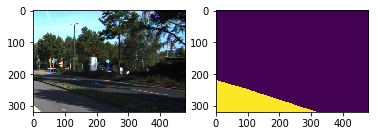

In [2]:
data = KittiRoadLoader(config)
img, mask = data.get_data_element("train_data",0)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask)
plt.show()

In [3]:
tf.reset_default_graph()

model = UNetModel(config)
model.build()

Model built successfully.


INFO:tensorflow:Restoring parameters from ./experiments\unet_kittiroad\saved_model/variables\variables
0.17291348


C:\Users\TT260256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
C:\Users\TT260256\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


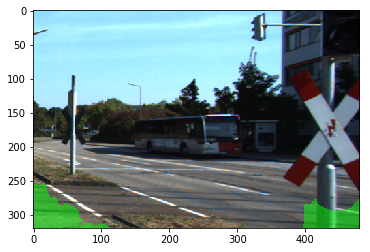

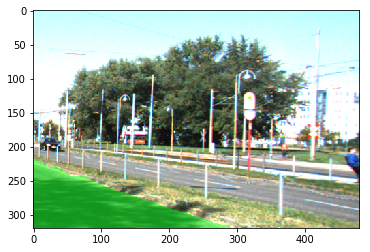

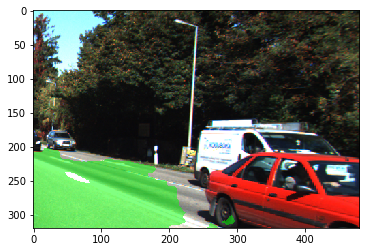

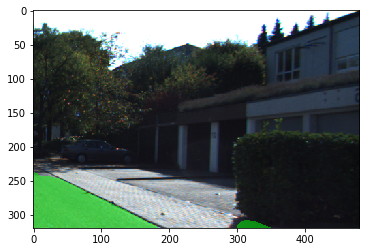

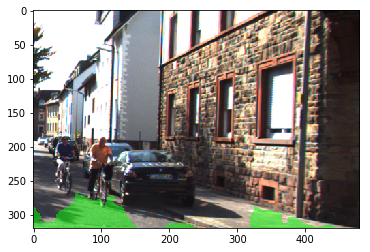

In [8]:
import numpy as np
import scipy
graph = tf.Graph()
with graph.as_default():
    with tf.Session() as sess:   
        tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.TRAINING], config.final_model_dir)    
        bl = sess.run("best_loss/best_loss:0")
        print(bl)        
#         for op in graph.get_operations():
#             print(op.name)
            
        X_test = graph.get_tensor_by_name("inputs/X:0")
        out_pred =  graph.get_tensor_by_name("output:0")
        
        test = [data.get_data_element("test_data",i) for i in range(5)]
        for item in test :
            img = item[0]
            mask = item[1]

            output_pred = sess.run(out_pred,feed_dict={X_test : [img]})
            segmentation = (output_pred>0.5).reshape(model.height,model.width,1)
            mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
            mask = scipy.misc.toimage(mask, mode="RGBA")
            street_im = scipy.misc.toimage(img)
            street_im.paste(mask, box=None, mask=mask)
            plt.imshow(street_im)
            plt.show()
#     trainer.train()
#     test = [data.get_data_element("test_data",i) for i in range(2)]
#     for item in test :
#         img = item[0]
#         mask = item[1]
#         model.predict(sess,img,mask)

In [ ]:
# tf.reset_default_graph()

# model = UNetModel(config)
# model.build()

# with tf.Session() as sess:   
#     logger = Logger(sess,config)
#     trainer = RoadTrainer(sess,model,data,config,logger)
# #     saver.restore(sess,tf.train.latest_checkpoint(config.checkpoint_dir))
#     model.load(sess)
#     #initializing all variables
# #     sess.run(tf.global_variables_initializer())
# #     bl = graph2.get_tensor_by_name("best_loss/best_loss:0")
# #     print(sess.run(bl))
# #         bl = sess.run("best_loss/best_loss:0")
# #         print(bl)
#     print(model.cur_epoch_tensor.eval())
#     print(model.global_step_tensor.eval())
#     print(model.best_loss.eval())
    

Model built successfully.
Loading final model 
INFO:tensorflow:Restoring parameters from ./experiments\unet_kittiroad\saved_model/variables\variables
Final model loaded


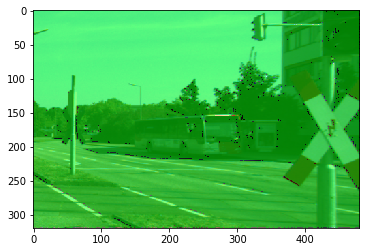

Accuracy :  0.05802323


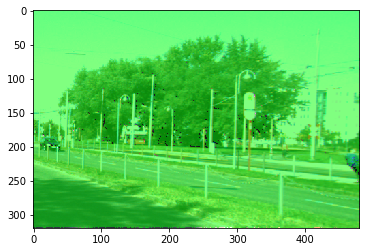

Accuracy :  0.15206067


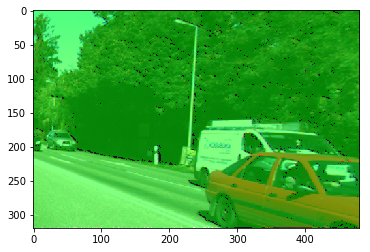

Accuracy :  0.24923109


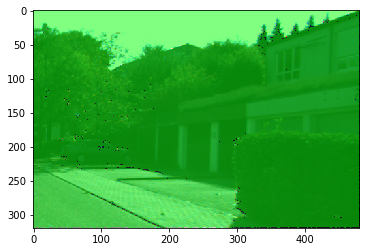

Accuracy :  0.09999368


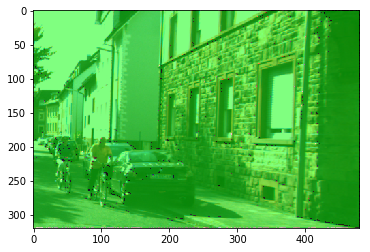

Accuracy :  0.12915048


In [9]:
tf.reset_default_graph()

model = UNetModel(config)
model.build()

with tf.Session() as sess:   
    sess.run(tf.global_variables_initializer())
    print("Loading final model ")
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.TRAINING], config.final_model_dir)
    print("Final model loaded") 
    test = [data.get_data_element("test_data",i) for i in range(5)]
    for item in test :
        img = item[0]
        mask = item[1]
        model.predict(sess,img,mask)